<div style="text-align: center;">

# Predictive Maintenance

</div>

---

*Created by* : 
 - DRISSI EL BOUZAIDI Oussama
 - ABRAM Ayoub
 - ELASSRI Soufiane
## 1. Project Overview

The *Predictive Maintenance* project focuses on building a predictive model that anticipates machine failures by analyzing historical data. This proactive approach enables timely maintenance, reducing unplanned downtime and enhancing operational efficiency.

<div style="text-align: center;">
    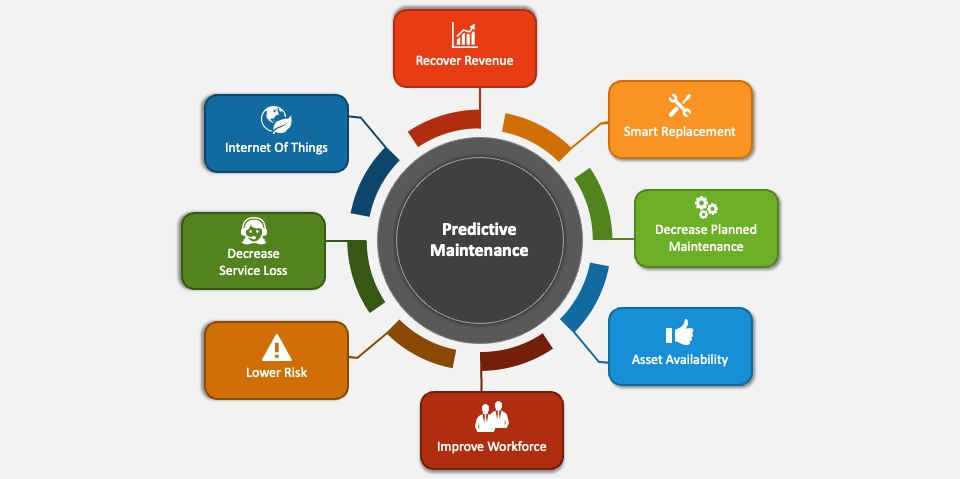
</div>


>


### Dataset Table Descriptions

The dataset originates from *Azure AI Notebooks* for Predictive Maintenance and consists of tables that capture various aspects of machine operations, errors, maintenance activities, failures, and specifications.

--

##### 📊 *Telemetry Table*

- *Description: Contains **hourly telemetry data* for each machine, offering insights into operational metrics that help monitor real-time conditions and flag unusual patterns.
- *Columns*:
  - datetime: Timestamp of the telemetry data record.
  - machineID: Unique identifier for each machine.
  - volt: Voltage level recorded from the machine's power system.
  - rotate: Rotation speed (RPM) of machine components.
  - pressure: Recorded pressure in the machine's system.
  - vibration: Vibration level, which may indicate potential stability issues.

---

##### ⚠ *Errors Table*

- *Description: Logs **error events* detected by machines. These non-fatal errors could indicate potential issues requiring attention.
- *Columns*:
  - datetime: Timestamp of the error occurrence.
  - machineID: Unique identifier for the affected machine.
  - errorID: Error type represented by an error code (e.g., error1, error3).

---

##### 🛠 *Maintenance Table*

- *Description: Tracks **maintenance actions* on each machine, offering insights into the impact of maintenance on machine reliability.
- *Columns*:
  - datetime: Date and time of the maintenance activity.
  - machineID: Unique identifier for the serviced machine.
  - comp: Component on which maintenance was performed (e.g., comp1, comp4).

---

##### ❌ *Failures Table*

- *Description: Logs **failure incidents* in machine components, crucial for identifying patterns and high-risk periods.
- *Columns*:
  - datetime: Timestamp of the component failure.
  - machineID: Unique identifier for the machine experiencing the failure.
  - failure: Specific component that failed (e.g., comp4).

---

##### 🏷 *Machines Table*

- *Description: Contains **basic information* about each machine in the dataset, aiding in the analysis of performance based on model type and age.
- *Columns*:
  - machineID: Unique identifier for each machine.
  - model: Model type of the machine (e.g., model3, model4).
  - age: Machine age in months.

---

Each dataset table provides a unique perspective on machine performance, reliability, and maintenance history, supporting detailed analysis and predictive modeling.

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

## 2. Data Preprocessing

In [121]:
telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_Machines.csv')

In [122]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [123]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [127]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [129]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [131]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [133]:
telemetry.isnull().sum()

datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64

In [135]:
print(errors.isnull().sum())

datetime     0
machineID    0
errorID      0
dtype: int64


In [137]:
maint.isnull().sum()

datetime     0
machineID    0
comp         0
dtype: int64

In [139]:
failures.isnull().sum()

datetime     0
machineID    0
failure      0
dtype: int64

In [141]:
machines.isnull().sum()

machineID    0
model        0
age          0
dtype: int64

In [143]:
telemetry.duplicated().sum()

0

# 3. Exploratory Data Analysis

## Telemetry

In [147]:
telemetry.iloc[:,2:].describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


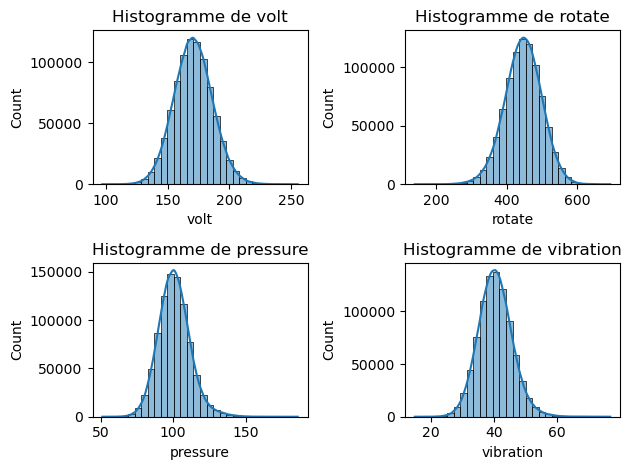

In [149]:
for i, col in enumerate(['volt', 'rotate', 'pressure', 'vibration']):
    plt.subplot(2, 2, i + 1)
    sns.histplot(telemetry[col], bins=30, kde=True)
    plt.title(f'Histogramme de {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

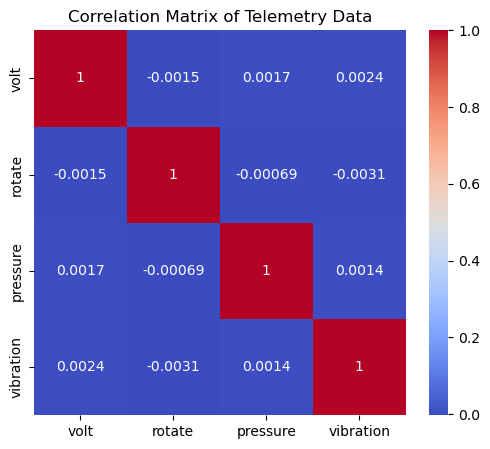

In [150]:
# Calculer la matrice de corrélation
correlation_matrix = telemetry[['volt', 'rotate', 'pressure', 'vibration']].corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Telemetry Data')
plt.show()

## Errors

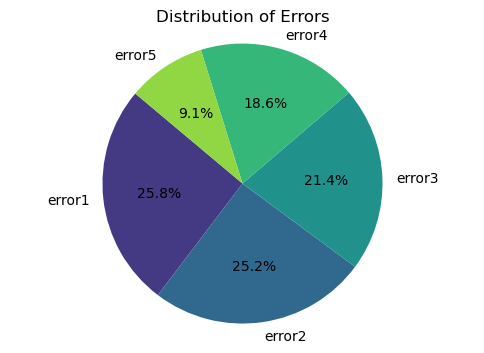

In [152]:
error_counts = errors['errorID'].value_counts().reset_index()
error_counts.columns = ['errorID', 'count']

# Create pie chart
plt.figure(figsize=(6, 4))
plt.pie(error_counts['count'], labels=error_counts['errorID'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(error_counts)))

# Add a title
plt.title("Distribution of Errors")

# Ensure pie chart is a circle
plt.axis('equal')

# Show the plot
plt.show()

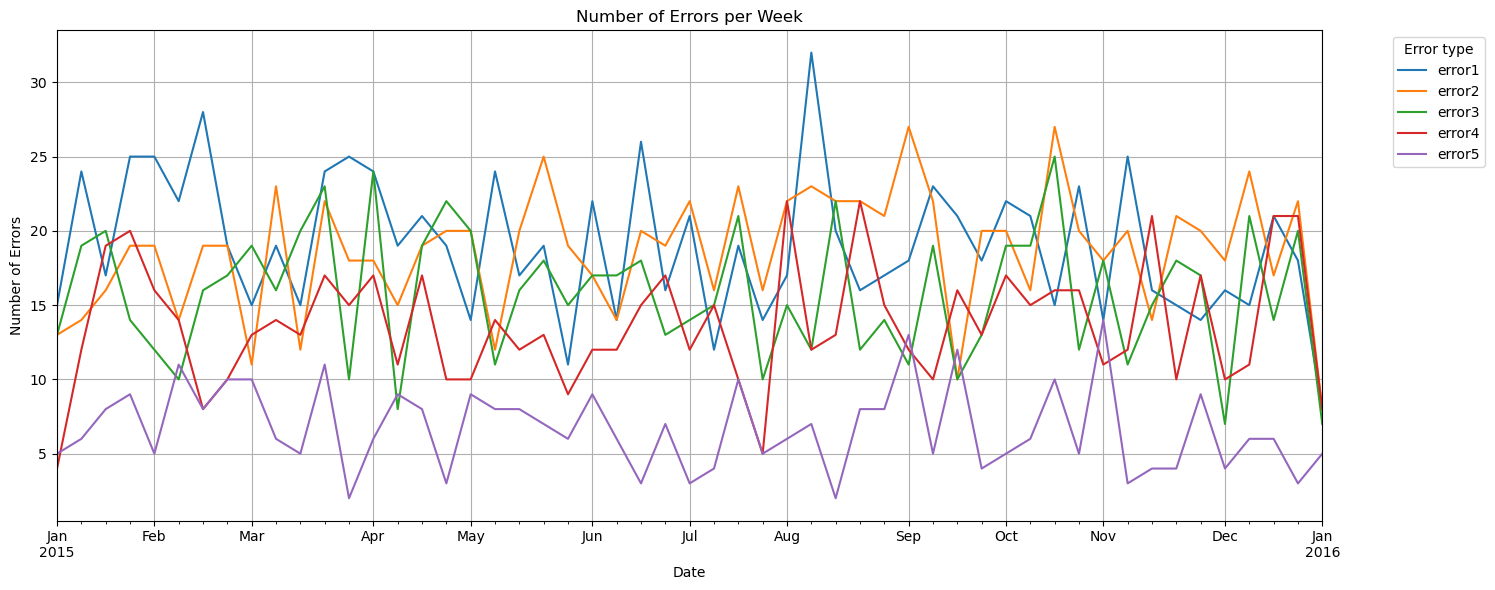

In [153]:
errors = pd.read_csv('PdM_errors.csv')

# Convertir la colonne 'datetime' en format datetime
errors['datetime'] = pd.to_datetime(errors['datetime'])

# Placer la colonne 'datetime' comme index pour pouvoir resampler par semaine
errors.set_index('datetime', inplace=True)

# Grouper les erreurs par semaine et par type d'erreur
errors_per_week = errors.groupby([pd.Grouper(freq='W'), 'errorID']).size().unstack(fill_value=0)

# Tracer les erreurs par semaine pour chaque type d'erreur
plt.figure(figsize=(15, 6))
errors_per_week.plot(kind='line', ax=plt.gca())  # Tracer sur la même figure

# Ajouter des titres et étiquettes
plt.title("Number of Errors per Week")
plt.xlabel("Date")
plt.ylabel("Number of Errors")
plt.grid(True)

# Afficher la légende
plt.legend(title='Error type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Afficher le graphique
plt.tight_layout()
plt.show()
errors = pd.read_csv('PdM_errors.csv')


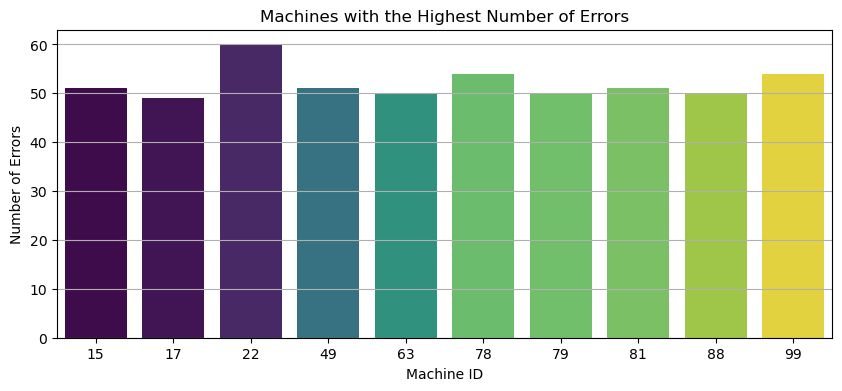

In [154]:
# Count the total number of errors per machine
errors_per_machine = errors.groupby('machineID').size().reset_index(name='error_count')

# Select the top 10 machines by number of errors
top_10_machines = errors_per_machine.nlargest(10, 'error_count')

# Visualize the errors by machine (Top 10)
plt.figure(figsize=(10, 4))
sns.barplot(data=top_10_machines, x='machineID', y='error_count', hue='machineID', palette='viridis', legend=False)
plt.title("Machines with the Highest Number of Errors")  # Updated title
plt.xlabel("Machine ID")  
plt.ylabel("Number of Errors") 
plt.grid(axis='y')
plt.show()

### Failures

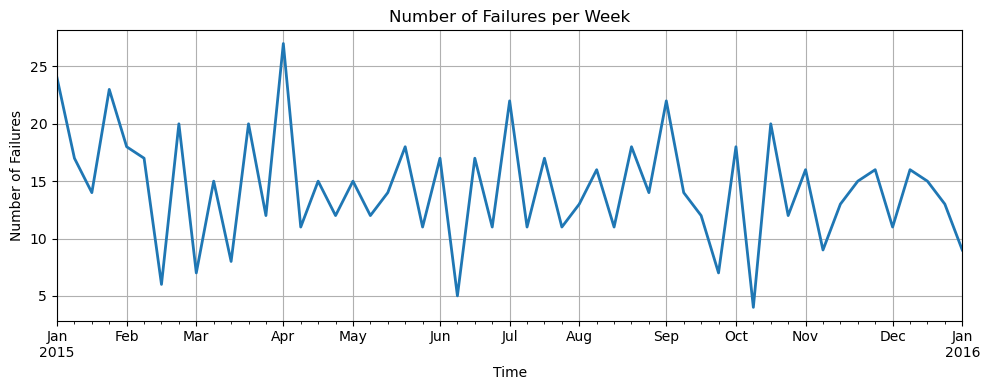

In [156]:
failures = pd.read_csv('PdM_failures.csv')

failures['datetime'] = pd.to_datetime(failures['datetime'])

# Set 'datetime' as the index
failures.set_index('datetime', inplace=True)

# Count the number of failures per week
failures_count = failures.resample('W').size()  # Count by week

# Visualize the number of failures over time
plt.figure(figsize=(10, 4))
failures_count.plot(title='Number of Failures per Week', linewidth=2)  # Added title and customization
plt.xlabel('Time')
plt.ylabel('Number of Failures')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
failures = pd.read_csv('PdM_failures.csv')

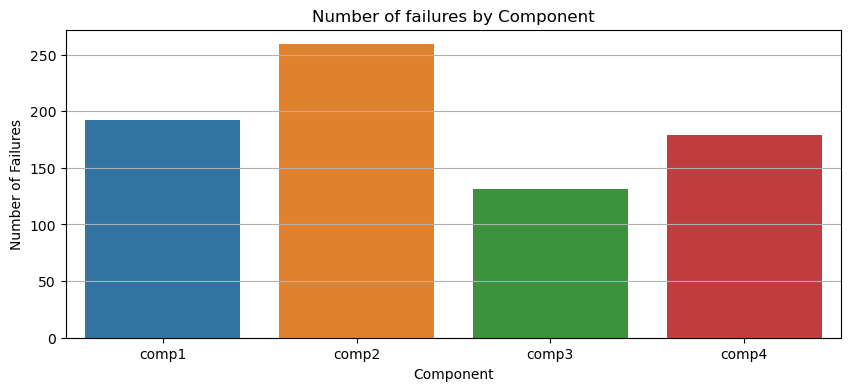

In [157]:
# Compter le nombre de pannes par composant
failures_per_component = failures.groupby('failure').size().reset_index(name='failure_count')

# Visualisation des pannes par composant avec hue
plt.figure(figsize=(10, 4))
sns.barplot(data=failures_per_component, x='failure', y='failure_count', hue='failure', dodge=False)
plt.title("Number of failures by Component")
plt.xlabel("Component")
plt.ylabel("Number of Failures")
plt.grid(axis='y')
plt.show()


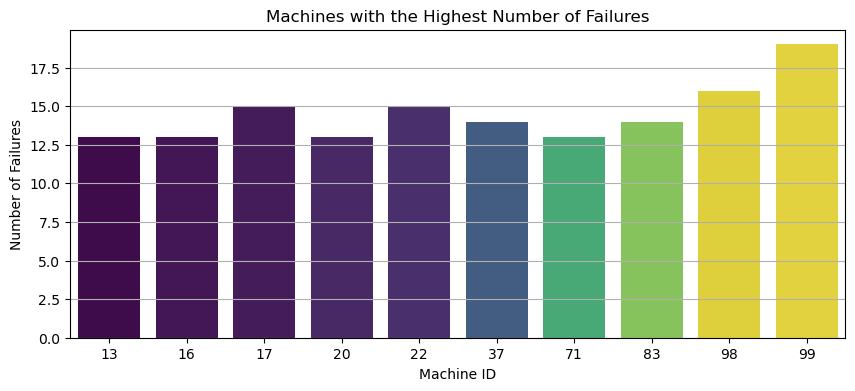

In [158]:

# Compter le nombre total de pannes par machine
failures_per_machine = failures.groupby('machineID').size().reset_index(name='failure_count')

# Sélectionner le top 10 des machines par nombre de pannes
top_10_machines = failures_per_machine.nlargest(10, 'failure_count')

# Visualiser les pannes par machine (Top 10)
plt.figure(figsize=(10, 4))
sns.barplot(data=top_10_machines, x='machineID', y='failure_count', hue='machineID', palette='viridis', legend=False)
plt.title("Machines with the Highest Number of Failures")  # Titre mis à jour
plt.xlabel("Machine ID")  
plt.ylabel("Number of Failures") 
plt.grid(axis='y')
plt.show()

### Machines

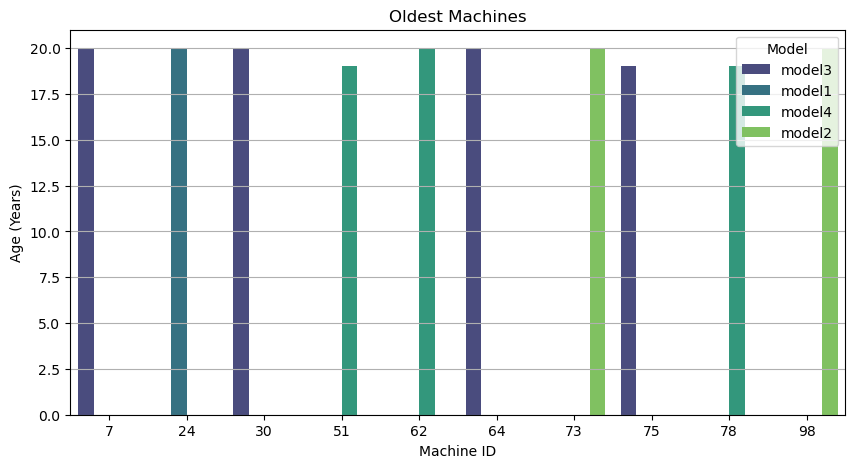

In [160]:
# Trier les machines par âge en ordre décroissant
machines_sorted = machines.sort_values(by='age', ascending=False).head(10)

# Visualiser les machines les plus anciennes (afficher toutes les machines car il n'y a que 5)
plt.figure(figsize=(10, 5))
sns.barplot(data=machines_sorted, x='machineID', y='age', hue='model', palette='viridis', dodge=True)
plt.title("Oldest Machines")
plt.xlabel("Machine ID")
plt.ylabel("Age (Years)")
plt.legend(title='Model')  # Correction du titre de la légende pour qu'il soit clair
plt.grid(axis='y')
plt.show()

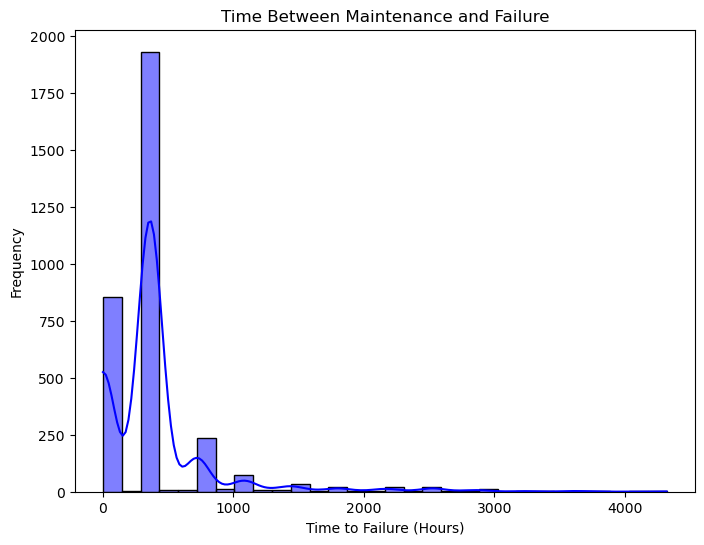

In [161]:
# Convert datetime columns to datetime format if not done already
maint['datetime'] = pd.to_datetime(maint['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])

# Ensure both dataframes are sorted by datetime
maint = maint.sort_values('datetime')
failures = failures.sort_values('datetime')

# Merge using outer join to check overlaps
maint_failures = pd.merge(
    maint,
    failures,
    on=['machineID', 'datetime'],
    how='outer',  # Using outer to see all possible combinations
    suffixes=('_maint', '_failure')
)

# Check if any maintenance dates occur before any failures
# If datetime columns are present, let's find the next failure for each maintenance
# We can do a merge with a time offset to match closest future failures
maint_failures['next_failure'] = maint_failures.groupby('machineID')['datetime'].shift(-1)

# Calculate time to failure (in hours) if next_failure is present
if 'next_failure' in maint_failures.columns:
    maint_failures['time_to_failure'] = (maint_failures['next_failure'] - maint_failures['datetime']).dt.total_seconds() / 3600
else:
    print("Next failure column not found.")

# Plot time between maintenance and failure
if 'time_to_failure' in maint_failures.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(maint_failures['time_to_failure'].dropna(), kde=True, bins=30, color='blue')
    plt.title('Time Between Maintenance and Failure')
    plt.xlabel('Time to Failure (Hours)')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No time to failure column found. Please check the merge operation.")


500 hours , approximatly 20 days to fail 

### Préparation des données pour le modèle :

In [174]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [176]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [178]:
failures.head(700000)

,datetime,machineID,failure
409,2015-01-02 03:00:00,56,comp3
739,2015-01-02 03:00:00,99,comp3
595,2015-01-02 03:00:00,83,comp4
430,2015-01-02 03:00:00,59,comp1
94,2015-01-02 03:00:00,16,comp1
...,...,...,...
389,2015-12-30 06:00:00,52,comp4
709,2015-12-31 06:00:00,95,comp1
668,2015-12-31 06:00:00,90,comp1
468,2015-12-31 06:00:00,64,comp1


In [180]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [182]:


failures['datetime'] = pd.to_datetime(failures['datetime'])
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])

merged_df = pd.merge(telemetry, failures, on=['datetime','machineID'], how='left')

# Ajout des informations de machines
merged_df = pd.merge(merged_df, machines, on='machineID', how='left')
merged_df.rename(columns={'machineID_x': 'machineID'},inplace = True)
# Ajout des informations d'erreurs
data = pd.merge(merged_df, errors, on=['datetime','machineID'], how='left')


In [183]:
data.isna().sum()

datetime          0
machineID         0
volt              0
rotate            0
pressure          0
vibration         0
failure      875684
model             0
age               0
errorID      872525
dtype: int64

In [185]:
data['failure'] = data['failure'].apply(lambda x : 0 if pd.isna(x) else 1)
data['errorID'] = data['errorID'].apply(lambda x : 0 if pd.isna(x) else 1)

In [187]:
data.groupby('failure')['machineID'].count()

failure
0    875684
1       761
Name: machineID, dtype: int64

Data is umbalanced !

In [191]:
data.drop_duplicates(inplace = True)

In [192]:
data.head(100)

,datetime,machineID,volt,rotate,pressure,vibration,failure,model,age,errorID
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,model3,18,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,model3,18,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,model3,18,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,model3,18,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,model3,18,0
...,...,...,...,...,...,...,...,...,...,...
95,2015-01-05 05:00:00,1,177.510419,469.787301,100.498426,59.577251,0,model3,18,0
96,2015-01-05 06:00:00,1,179.303153,499.777962,111.833028,52.383097,1,model3,18,0
97,2015-01-05 07:00:00,1,155.511452,498.398435,103.068134,33.270415,0,model3,18,0
98,2015-01-05 08:00:00,1,172.439821,392.124959,108.135159,39.477497,0,model3,18,0


In [195]:
data.drop(columns = {'model'},inplace = True)

In [197]:
data

,datetime,machineID,volt,rotate,pressure,vibration,failure,age,errorID
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,18,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,18,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,18,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,18,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,18,0
...,...,...,...,...,...,...,...,...,...
876440,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,0,5,0
876441,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,0,5,0
876442,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,0,5,0
876443,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,0,5,0


In [199]:
data['datetime'] = data['datetime'].astype('int64')

In [201]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876100 entries, 0 to 876444
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  int64  
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
 6   failure    876100 non-null  int64  
 7   age        876100 non-null  int64  
 8   errorID    876100 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 66.8 MB


#### Balancing data 

In [204]:
X = data.drop(columns=['failure']) 
y = data['failure']

In [206]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to features and target
X_resampled, y_resampled = smote.fit_resample(X, y)

In [208]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['failure'])

resampled_data = pd.concat([X_resampled_df, y_resampled_df], axis=1)


In [210]:
resampled_data.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,errorID,failure
0,1420092000000000000,1,176.217853,418.504078,113.077935,45.087686,18,0,0
1,1420095600000000000,1,162.879223,402.747490,95.460525,43.413973,18,0,0
2,1420099200000000000,1,170.989902,527.349825,75.237905,34.178847,18,0,0
3,1420102800000000000,1,162.462833,346.149335,109.248561,41.122144,18,0,0
4,1420106400000000000,1,157.610021,435.376873,111.886648,25.990511,18,0,0


In [212]:
resampled_data['datetime'] = pd.to_datetime(resampled_data['datetime'])

In [214]:
resampled_data.head()

,datetime,machineID,volt,rotate,pressure,vibration,age,errorID,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,18,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,18,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,18,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,18,0,0


In [216]:
df_sorted = resampled_data.sort_values(by='datetime', ascending=True)

In [218]:
df_sorted
df_2 = df_sorted.copy()
df_2

,datetime,machineID,volt,rotate,pressure,vibration,age,errorID,failure
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,18,0,0
403006,2015-01-01 06:00:00,47,152.469771,397.844508,96.225557,43.310259,6,0,0
411767,2015-01-01 06:00:00,48,165.826672,373.914499,118.363351,48.985910,10,0,0
219025,2015-01-01 06:00:00,26,151.572346,396.728690,97.224123,42.615226,3,0,0
657075,2015-01-01 06:00:00,76,178.053065,381.134168,110.193941,43.576702,10,0,0
...,...,...,...,...,...,...,...,...,...
665835,2016-01-01 06:00:00,76,175.176499,491.345068,116.362892,37.419137,10,0,0
131414,2016-01-01 06:00:00,15,196.508873,497.583760,124.921627,39.531999,14,0,0
674596,2016-01-01 06:00:00,77,183.235719,480.994165,82.748501,40.263902,12,0,0
140175,2016-01-01 06:00:00,16,174.975151,448.188020,95.443904,41.866917,3,0,0


#### Training data using XGBOOST model

In [220]:
df_sorted = df_sorted.set_index('datetime').sort_index()

 # Drop rows with NaN values from lagging
df_sorted['year'] = df_sorted.index.year
df_sorted['month'] = df_sorted.index.month
df_sorted['day'] = df_sorted.index.day
df_sorted['day_of_week'] = df_sorted.index.dayofweek
df_sorted['hour'] = df_sorted.index.hour 
# Define features and failure
X = df_sorted[['year', 'month', 'day', 'day_of_week', 'hour', 'machineID', 'volt', 'rotate', 'pressure', 'vibration', 'age', 'errorID']]
y = df_sorted['failure']

# Train-Test Split (time-based split)
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize and train XGBoost model
model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=50, 
    learning_rate=0.1,
    max_depth=3,           # Modify this value as needed
    min_child_weight=1     # Modify this value as needed
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.15711095224674151
Mean Absolute Error: 0.345325949787312


In [222]:
predictions_df = X_test.copy()
predictions_df['Predicted_Failure'] = y_pred
predictions_df['Actual_Failure'] = y_test

In [224]:
predictions_df.head()

,year,month,day,day_of_week,hour,machineID,volt,rotate,pressure,vibration,age,errorID,Predicted_Failure,Actual_Failure
datetime,,,,,,,,,,,,,,
2015-10-17 09:16:50.265516544,2015,10,17,5,9,63,159.629197,435.322250,113.040201,49.833094,16,0,0.620547,1
2015-10-17 09:18:09.384952832,2015,10,17,5,9,20,206.227210,436.688439,104.209053,51.642858,16,0,0.633821,1
2015-10-17 09:18:18.287703296,2015,10,17,5,9,23,208.400077,434.495092,106.467928,49.262704,15,0,0.633821,1
2015-10-17 09:18:49.063762432,2015,10,17,5,9,54,172.966620,321.319313,115.381668,32.475631,15,0,0.498307,1
2015-10-17 09:19:44.970690560,2015,10,17,5,9,20,206.164056,436.667173,104.209634,51.646493,16,0,0.633821,1


In [114]:
y_pred

array([0.62054706, 0.63382095, 0.63382095, ..., 0.7809332 , 0.701649  ,
       0.91976994], dtype=float32)

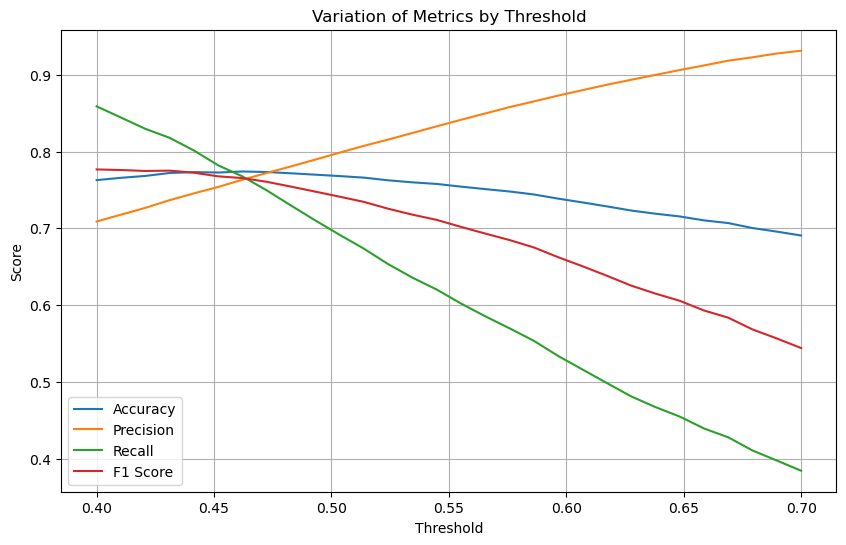

Best Threshold by Accuracy: 0.46 with Accuracy: 0.7741


In [230]:

# Define thresholds
thresholds = np.linspace(0.4, 0.7, 30)  # Adjust range and step as needed
best_threshold = 0
best_accuracy = 0

# To store metrics for each threshold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred_binary = (y_pred >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # Append metrics to respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Update best threshold based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Plot metrics over thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_list, label="Accuracy")
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")

# Add labels, title, and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Variation of Metrics by Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Print the best threshold based on accuracy
print(f"Best Threshold by Accuracy: {best_threshold:.2f} with Accuracy: {best_accuracy:.4f}")


In [232]:
failure_predictions = (y_pred >= 0.46).astype(int)
predictions_df['pred_class'] = failure_predictions

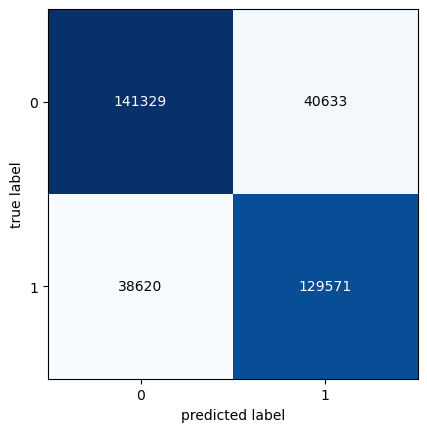

In [234]:
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=predictions_df['pred_class'], 
                      binary=True)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [236]:
cl = classification_report(y_test, predictions_df['pred_class'])
print(cl)

              precision    recall  f1-score   support

           0       0.79      0.78      0.78    181962
           1       0.76      0.77      0.77    168191

    accuracy                           0.77    350153
   macro avg       0.77      0.77      0.77    350153
weighted avg       0.77      0.77      0.77    350153



#### XGBOOST with lagging

In [241]:
df_2['datetime'] = pd.to_datetime(df_2['datetime'])
df_2 = df_2.set_index('datetime').sort_index()

df_2['lag_1'] = df_2['failure'].shift(1)
df_2['lag_2'] = df_2['failure'].shift(2)
df_2['lag_3'] = df_2['failure'].shift(3)

# Drop NaN rows due to lagging
df_2 = df_2.dropna()

df_2['year'] = df_2.index.year
df_2['month'] = df_2.index.month
df_2['day'] = df_2.index.day
df_2['day_of_week'] = df_2.index.dayofweek
df_2['hour'] = df_2.index.hour 
# Define features and failure
X = df_2[['year', 'month', 'day', 'day_of_week', 'hour', 'lag_1', 'lag_2', 'lag_3', 'machineID', 'volt', 'rotate', 'pressure', 'vibration', 'age', 'errorID']]
y = df_2['failure']

# Train-Test Split (time-based split)
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize and train XGBoost model
model = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=50, 
    learning_rate=0.1,
    max_depth=3,           # Modify this value as needed
    min_child_weight=1     # Modify this value as needed
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 0.02043019899998513
Mean Absolute Error: 0.04727513556437939


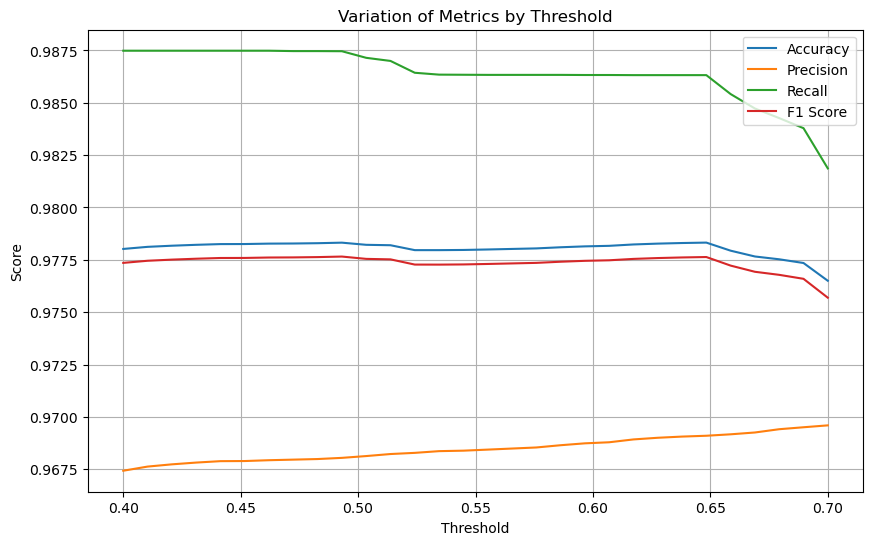

Best Threshold by Accuracy: 0.65 with Accuracy: 0.9783


In [243]:
# Define thresholds
thresholds = np.linspace(0.4, 0.7, 30)  # Adjust range and step as needed
best_threshold = 0
best_accuracy = 0

# To store metrics for each threshold
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Calculate metrics for each threshold
for threshold in thresholds:
    y_pred_binary = (y_pred >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # Append metrics to respective lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    # Update best threshold based on accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Plot metrics over thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_list, label="Accuracy")
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, label="F1 Score")

# Add labels, title, and legend
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Variation of Metrics by Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Print the best threshold based on accuracy
print(f"Best Threshold by Accuracy: {best_threshold:.2f} with Accuracy: {best_accuracy:.4f}")


In [245]:
results = X_test.copy()
results['Predicted_Failure'] = y_pred
results['Actual_Failure'] = y_test
failure_predictions = (y_pred >= 0.65).astype(int)
results['pred_class'] = failure_predictions

In [247]:
results.head()

,year,month,day,day_of_week,hour,lag_1,lag_2,lag_3,machineID,volt,rotate,pressure,vibration,age,errorID,Predicted_Failure,Actual_Failure,pred_class
datetime,,,,,,,,,,,,,,,,,,
2015-10-17 09:18:09.384952832,2015,10,17,5,9,1.0,1.0,1.0,20,206.227210,436.688439,104.209053,51.642858,16,0,0.987193,1,1
2015-10-17 09:18:18.287703296,2015,10,17,5,9,1.0,1.0,1.0,23,208.400077,434.495092,106.467928,49.262704,15,0,0.987193,1,1
2015-10-17 09:18:49.063762432,2015,10,17,5,9,1.0,1.0,1.0,54,172.966620,321.319313,115.381668,32.475631,15,0,0.969210,1,1
2015-10-17 09:19:44.970690560,2015,10,17,5,9,1.0,1.0,1.0,20,206.164056,436.667173,104.209634,51.646493,16,0,0.987193,1,1
2015-10-17 09:20:05.362668544,2015,10,17,5,9,1.0,1.0,1.0,60,157.465339,437.451930,110.782041,52.201941,18,0,0.971856,1,1


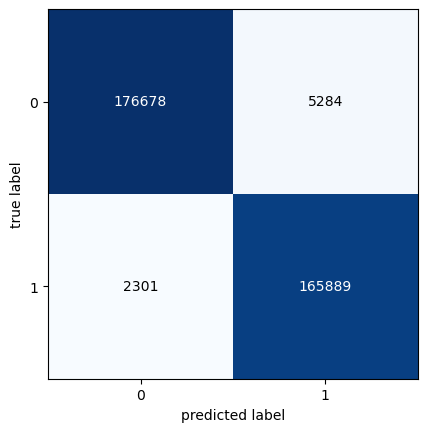

In [249]:
cm = confusion_matrix(y_target=y_test, 
                      y_predicted=results['pred_class'], 
                      binary=True)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [334]:
data = {
    'year': [2023, 2023, 2023, 2023],
    'month': [8, 8, 8, 8],
    'day': [13, 13, 13, 13],
    'day_of_week': [2, 2, 2, 2],
    'hour': [14, 15, 16, 17],
    'lag_1': [0, 1, 0, 1],  # Example binary flag for failure indication
    'lag_2': [0, 1, 0, 1],
    'lag_3': [0, 1, 0, 1],
    'machineID': [1, 2, 3, 4],
    'volt': [225.4, 325.7, 125.5, 126.0],
    'rotate': [420, 425, 415, 430],
    'pressure': [140.5, 45.3, 40.6, 250.4],
    'vibration': [20, 35, 34, 45],
    'age': [20, 25, 23, 24],
    'errorID': [0, 0, 0, 0]
}
# Create a DataFrame
test_df = pd.DataFrame(data)
test_df.head()

,year,month,day,day_of_week,hour,lag_1,lag_2,lag_3,machineID,volt,rotate,pressure,vibration,age,errorID
0,2023,8,13,2,14,0,0,0,1,225.4,420,140.5,20,20,0
1,2023,8,13,2,15,1,1,1,2,325.7,425,45.3,35,25,0
2,2023,8,13,2,16,0,0,0,3,125.5,415,40.6,34,23,0
3,2023,8,13,2,17,1,1,1,4,126.0,430,250.4,45,24,0


Lstm Epoch 1/50
22669/43769 ━━━━━━━━━━━━━━━━━━━━ 2:19 7ms/step - loss: 0.0666

In [337]:
predictions = model.predict(test_df)

In [339]:
predictions

array([ 0.01117385,  0.24399738, -0.00302782,  0.452252  ], dtype=float32)